## cGAN generate LiDAR

In [45]:
import os
import io
import cv2
import copy
import math
import wandb
import random
import numpy as np
import warnings
import pickle as pkl
from collections import deque
from tqdm import tqdm, trange
from typing import Deque, Dict, List, Tuple
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split



## dataset

In [2]:

name_corridor = ['0717_1411', 
                '0720_1129',
                '0722_1428',
                '0722_1437',
                '0722_1448',
                '0722_1500',
                '0722_1506',
                '0722_1510',
                '0722_1514',
                '0724_1101',
                '0724_1132',
                '0724_1204',
                '0727_1005',
                '0727_1027',
                '0727_1102',
                '0727_1435',
                '0727_1452',
                '0727_1510',
                '0727_1520',
                '0805_1108',
                '0805_1127',
                '0805_1147']

name_parking = ['0717_1504',
                '0720_1105',
                '0805_1349',
                '0805_1425']

paths_corridor, paths_parking = [], []

main_path = '/media/ray/intelSSD/mmdemo_train'
dirs = os.listdir(main_path)
dirs.sort()
for d in dirs:
    dirs1 = os.listdir(main_path+'/'+d)
    dirs1.sort()
    dirs2 = os.listdir(main_path+'/'+d+'/'+dirs1[1])
    dirs2.sort()
    for d2 in dirs2:
        if any(s in d2 for s in name_corridor):
            paths_corridor.append(main_path+'/'+d+'/'+dirs1[1]+'/'+d2)
#             print(paths_corridor[-1])
        elif any(s in d2 for s in name_parking):
            paths_parking.append(main_path+'/'+d+'/'+dirs1[1]+'/'+d2)
#             print(paths_parking[-1])
            
print('%d episodes'%len(paths_corridor))
print('%d episodes'%len(paths_parking))


153 episodes
31 episodes


In [3]:
class MMDataset(Dataset):
    def __init__(self, paths):
        self.transitions = []

        for p in tqdm(paths):
            with open(p, "rb") as f:
                demo = pkl.load(f, encoding="bytes")
                self.transitions.extend(demo)
        
    def __getitem__(self,index):
        mm_scan = self.transitions[index][b'mm_scan']
        laser_scan = self.transitions[index][b'laser_scan']
        mm_scan = torch.Tensor(mm_scan).reshape(1,-1)
        laser_scan = torch.Tensor(laser_scan).reshape(1,-1)
        
        return mm_scan, laser_scan
    
    def __len__(self):
        return len(self.transitions)

    
batch_size = 128

corridor_dataset = MMDataset(paths_corridor)
loader_corridor = DataLoader(dataset=corridor_dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=4)

parking_dataset = MMDataset(paths_parking)
loader_parking = DataLoader(dataset=parking_dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=4)


100%|██████████| 31/31 [00:00<00:00, 92.21it/s]


## fit

In [4]:
def laser_visual(lasers=[], show=False, range_limit=6):
    fig = plt.figure(figsize=(8, 8))
    colors = ['#3483EB','#FFA500','#15B01D']
    for i, l in enumerate(lasers):
        
        angle = 120
        xp = []
        yp = []
        for r in l:
            if r <= range_limit:
                yp.append(r * math.cos(math.radians(angle)))
                xp.append(r * math.sin(math.radians(angle)))
            angle -= 1
        plt.xlim(-6, 6)
        plt.ylim(-6, 6)
        plt.axis('off')
        plt.plot(xp, yp, 'x', color=colors[i])
#         plt.show()


In [58]:
def curve_fit(mm, order = 15):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', np.RankWarning)
        indx = np.where(mm<4.9)[0]
        if len(indx)==0: return mm
        
        try:
            z = np.polyfit(indx, mm[indx], order)
        except:
            return mm
        
        xp = np.linspace(0, 240, 241)
        p = np.poly1d(z)

        fit = np.clip(p(xp), 0, 5)
    #     plt.plot(indx,mm[indx],'o')
    #     plt.plot(xp, fit)

        return fit

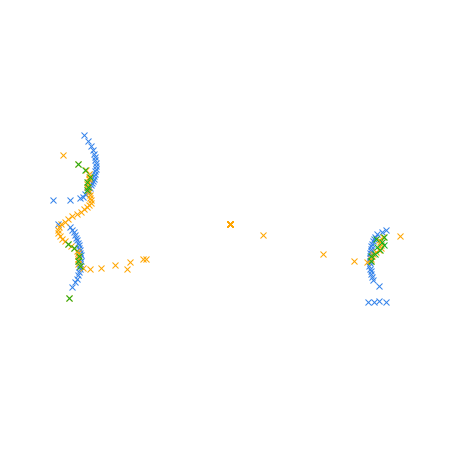

In [99]:
for mm_scan, laser_scan in loader_parking:
    mm_scan = mm_scan.numpy()[0][0]
    laser_scan = laser_scan.numpy()[0][0]
    
    fit = curve_fit(mm_scan)
    laser_visual([laser_scan, fit, mm_scan], range_limit=4.9)
    
    break

## L1

In [7]:
l1 = nn.L1Loss()

### L1 curve fit

In [67]:
l1_order = []
for order in range(5,15):
    L1 = []
    t = tqdm(loader_corridor)
    for mm_scan, laser_scan in t:
        fit = []
        mm_scan = mm_scan.numpy()
        for mm in mm_scan:
            fit.append([curve_fit(mm[0], order=order)])
        fit = torch.Tensor(fit)
        L1.append(l1(laser_scan,fit))
    l1_order.append(np.mean(L1))

for i, l in enumerate(l1_order):
    print("\n order %d corridor L1: %.4f"%(i+5,l))

 11%|█▏        | 66/582 [00:01<00:14, 35.05it/s]/home/ray/.local/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
 34%|███▍      | 198/582 [00:05<00:11, 34.89it/s]/home/ray/.local/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
  3%|▎         | 15/582 [00:00<00:19, 29.39it/s]/home/ray/.local/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
 31%|███       | 179/582 [00:05<00:11, 34.40it/s]/home/ray/.local/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
  1%|          | 6/582 [00:00<00:25, 22.70it/s]/home/ray/.local/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
 54%|█████▍    | 314/582 [00:


 order 0 corridor L1: 0.8438

 order 1 corridor L1: 0.7611

 order 2 corridor L1: 0.7764

 order 3 corridor L1: 0.7576

 order 4 corridor L1: 0.8034

 order 5 corridor L1: 0.8514

 order 6 corridor L1: 0.9150

 order 7 corridor L1: 0.9685

 order 8 corridor L1: 1.0108

 order 9 corridor L1: 1.0531


In [68]:
l1_order = []
for order in range(5,15):
    L1 = []
    t = tqdm(loader_parking)
    for mm_scan, laser_scan in t:
        fit = []
        mm_scan = mm_scan.numpy()
        for mm in mm_scan:
            fit.append([curve_fit(mm[0], order=order)])
        fit = torch.Tensor(fit)
        L1.append(l1(laser_scan,fit))
    l1_order.append(np.mean(L1))

for i, l in enumerate(l1_order):
    print("\n order %d parkin L1: %.4f"%(i+5,l))

  2%|▏         | 2/120 [00:00<00:06, 18.43it/s]/home/ray/.local/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
 62%|██████▏   | 74/120 [00:02<00:01, 35.97it/s]/home/ray/.local/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
 65%|██████▌   | 78/120 [00:02<00:01, 36.00it/s]/home/ray/.local/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
 42%|████▏     | 50/120 [00:01<00:02, 34.70it/s]/home/ray/.local/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
 55%|█████▌    | 66/120 [00:01<00:01, 35.24it/s]/home/ray/.local/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
 95%|█████████▌| 114/120 [00:03


 order 5 parkin L1: 1.3629

 order 6 parkin L1: 1.3807

 order 7 parkin L1: 1.4545

 order 8 parkin L1: 1.5232

 order 9 parkin L1: 1.5814

 order 10 parkin L1: 1.6573

 order 11 parkin L1: 1.6905

 order 12 parkin L1: 1.7167

 order 13 parkin L1: 1.7396

 order 14 parkin L1: 1.7876


### L1 raw

In [11]:
L1 = []
t = tqdm(loader_corridor)
for mm_scan, laser_scan in t:
    
    L1.append(l1(laser_scan,mm_scan))

print("\n corridor L1: %.4f"%np.mean(L1))

100%|██████████| 582/582 [00:00<00:00, 986.08it/s]


 corridor L1: 1.9953


In [100]:
L1 = []
t = tqdm(loader_parking)
for mm_scan, laser_scan in t:
    
    L1.append(l1(laser_scan,mm_scan))
    
print("\n parking L1: %.4f"%np.mean(L1))

100%|██████████| 120/120 [00:00<00:00, 799.39it/s]


 parking L1: 0.3904


### L1 interpolation

In [11]:
L1 = []
t = tqdm(loader_parking)
for mm_scan, laser_scan in t:
    mm_scan = mm_scan.to(device)
    
    x_hat = model(mm_scan)
    x_hat = x_hat.detach().cpu().numpy().reshape(mm_scan.size(0),-1)
    laser_scan = laser_scan.numpy().reshape(mm_scan.size(0),-1)
    mm_scan = mm_scan.detach().cpu().numpy().reshape(mm_scan.size(0),-1)
    
    l1 = np.mean(np.abs(laser_scan-x_hat))
    L1.append(l1)
    
print("\n parking L1: %.4f"%np.mean(L1))

100%|██████████| 120/120 [00:00<00:00, 352.61it/s]


 parking L1: 0.1114
